# Model Training and Evaluation

#### Feature Engineering (for text)

1. **Random Baseline**: randomly predict "success" based on empirical success rate observed in training data

2. **Featurized**: semantic features motivated by prior literature and domain knowledge of the platform

3. **N-Gram**: TF-IDF model with unigrams and bigrams scaled by overall frequency

4. **Transformer**: Pre-trained and fine-tuned transformers for encoding textual content into vectors


#### Prediction Models

1. Logistic regression with L1 penalty

2. XGBoost

#### Performance Metrics (out-of-sample)

1. AUROC: tradeoff between type I and type II error. Can be interpreted as "probability that a randomly chosen successful request has a higher predicted probability than a randomly chosen unsuccessful request"

2. Accuracy: percent of referral requests with correct labels

3. Recall: percent of successful requests that are correctly identified

4. Precision: Percent of predicted successes that were actually successful

5. F1-Score: Harmonic mean between precision and recall

6. Calibration Plots: Plots true success rates (Y) against predicted success rates (X) within each quantile bin. Model overpredicts success if below 45-degree line, and under-predicts if above it. 

#### F1, Recall, Precision for Random Baseline:

Let $p$ denote the proportion of referral requests receiving referral offers from other users in training data. 

Random Baseline predicts randomly predicts that a referral request will receive an offer with probability $p$. 

These are the implied Recall, Precision, and F1 Scores for the random baseline

$\text{Recall} = \frac{TP}{TP + FN} = \frac{TP}{\text{underlying positive}} = p$ since True will be predicted with probability $p$.

$\text{Precision} = \frac{TP}{TP+FP} = \frac{TP / N}{\text{predicted positive} / N} = \frac{Prob(TP)}{p} = \frac{p * p}{p} = p$

$\text{F1} = (2 * \text{Precision} * \text{Recall}) / (\text{Precision} + \text{Recall}) = \frac{2 * p * p}{p + p} = p$

## Train models to predict referral offers (binary)

In [ ]:
# Fine-tune transformers to encode text into embeddings (exports data/clean/posts_encode_*.pkl)
# !python3 dataprep/encode.py

In [ ]:
# Train logistic / XGBoost models using transformer embeddings
# (exports data.joblib and model.joblib under the data/train/ folder)
# !python3 modelfit/train.py

## Load packages & trained model / data

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
# Packages and Directories
from setup.utils import *

# Modules for Performance Evaluation
import modelfit.performance as pf

# Load trained model and data
data = joblib.load(f'{TRAIN}/data.joblib')
predmod = joblib.load(f'{TRAIN}/model.joblib')

In [20]:
perf_report = lambda metrics, conf: [f"{k} = {metrics[k]} {conf[k]}" for k in metrics]

## Featurized Model

Semantic features are motivated by insights from prior literature and our domain knowledge of the discussion platform. Training a logistic regression model on these features is helpful for interpretation and lingusitic analysis, but it has worse predictive performance than either n-gram models or transformers. 

AUROC = 0.576, Accuracy = 0.562, F1-Score = 0.559

Predicted success rates (X) are reasonably close to true success rates, but featurized model slightly overstates true success under 0.50 while understating it below 0.50.

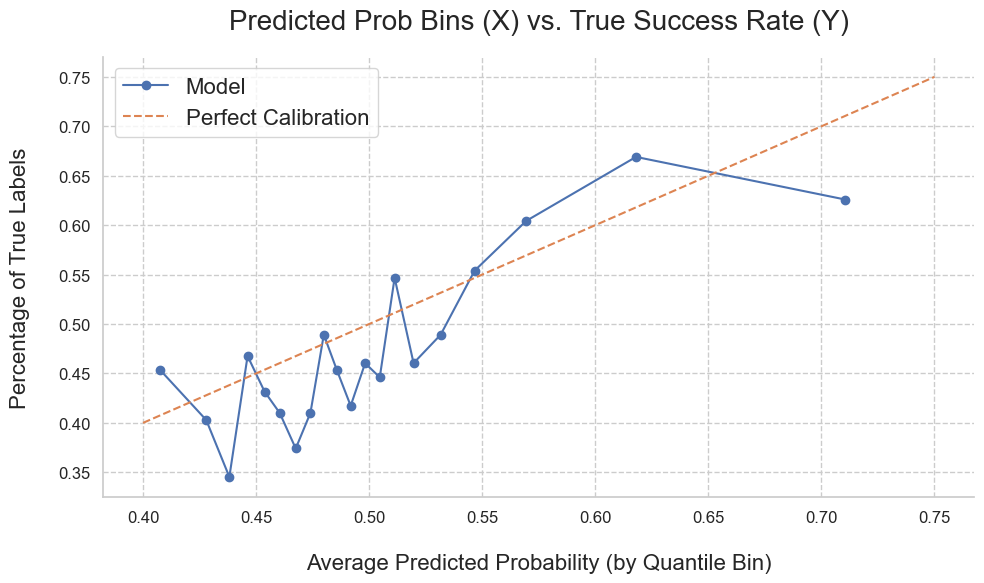

In [5]:
# No L1 penalty (good for interpretation)
metrics, conf = pf.evaluate_model(data, predmod, 'domain_full_base', bstrap=True)

In [6]:
perf_report(metrics, conf)

['accuracy = 0.562 (0.543, 0.581)',
 'f1_score = 0.559 (0.54, 0.578)',
 'precision = 0.545 (0.516, 0.573)',
 'recall = 0.472 (0.447, 0.501)',
 'roc_auc = 0.576 (0.554, 0.597)']

Handling non-linear interactions with XGBoost does not meaningfully improve this performance. Calibration plots also indicate that it exacerbates over-stating low success rates while under-stating higher success rates

AUROC = 0.576 (logistic) > 0.561 (xgboost).

We will focus on logistic regression models going forward. 

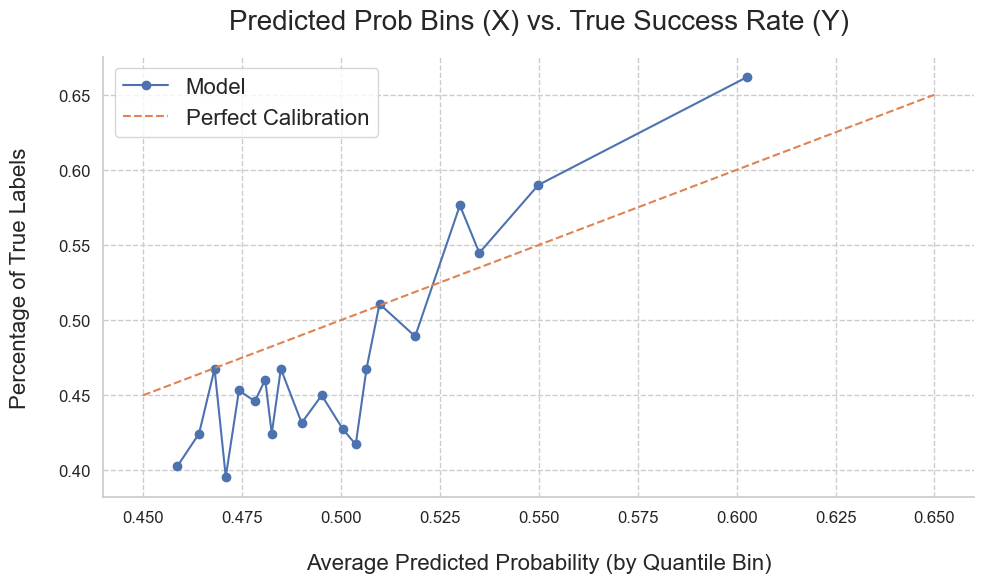

In [9]:
# Featurized Model with XGB
metrics, conf = pf.evaluate_model(data, predmod, 'domain_full_xgb', bstrap=True)

In [10]:
perf_report(metrics, conf)

['accuracy = 0.545 (0.525, 0.564)',
 'f1_score = 0.543 (0.523, 0.562)',
 'precision = 0.524 (0.495, 0.552)',
 'recall = 0.476 (0.448, 0.505)',
 'roc_auc = 0.561 (0.539, 0.583)']

#### N-Gram Models

These models use TF-IDF to scale unigram/bigram frequencies using overall frequency across all referral requests. 

They outperform featurized models by a large margin

AUROC = 0.647 (n-gram) > 0.576 (featurized)

True success rates are closer to predicted success rates (closer to 45-degree line) compared with featurized models

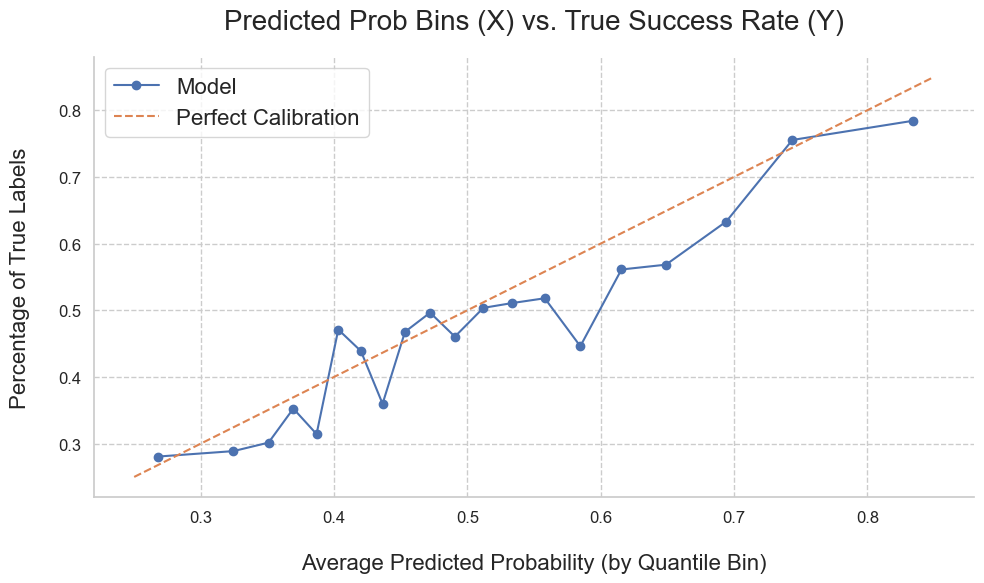

In [11]:
metrics, conf = pf.evaluate_model(data, predmod, 'ngram_logit', bstrap=True)

In [12]:
perf_report(metrics, conf)

['accuracy = 0.602 (0.585, 0.619)',
 'f1_score = 0.601 (0.584, 0.619)',
 'precision = 0.586 (0.558, 0.612)',
 'recall = 0.556 (0.527, 0.581)',
 'roc_auc = 0.647 (0.627, 0.667)']

#### Transformers

We took a pre-trained sentence-transformer open sourced on `hugging face`.

This outperforms both n-gram and featurized models.

AUROC = 0.679 (transformer) > 0.647 (n-gram) > 0.576 (featurized).

Predicted success rates from transformers are even closer to predicted success rates than n-gram models.

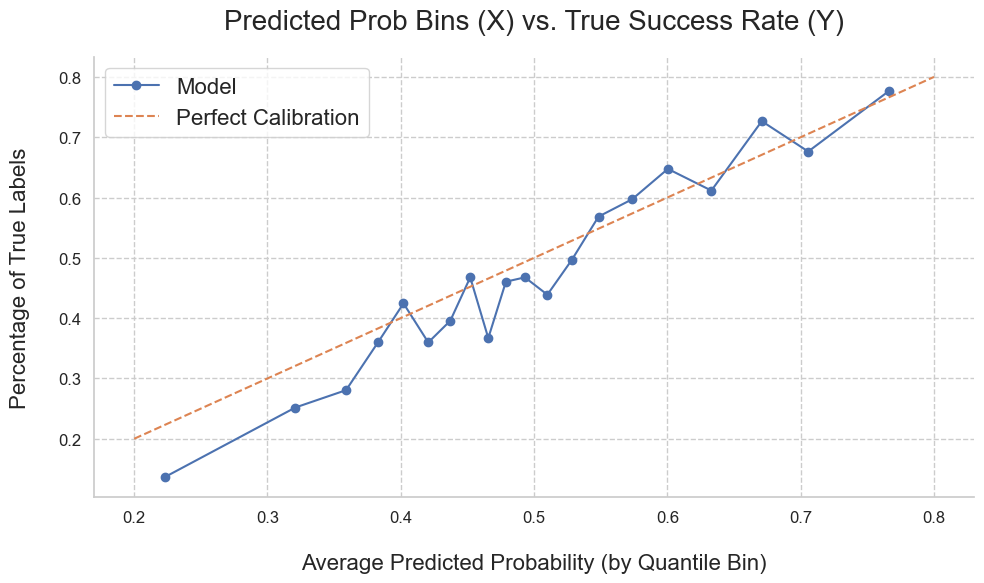

In [24]:
metrics, conf = pf.evaluate_model(data, predmod, 'bert_sent_base_logit', bstrap=True)

In [25]:
perf_report(metrics, conf)

['accuracy = 0.625 (0.607, 0.641)',
 'f1_score = 0.624 (0.606, 0.641)',
 'precision = 0.61 (0.583, 0.637)',
 'recall = 0.583 (0.557, 0.609)',
 'roc_auc = 0.679 (0.66, 0.696)']

We fine-tuned the sentence transformer to make it better at predicting whether referral requests receive referral offers from other users. 

Fine-tuned transformers perform slightly better than pre-trained transformers across all performance metrics (but likely not statistically significant)

<center>

| Performance Metric | Fine-tuned |      | Pre-Trained |
| :----------------: | :--------: | :--: | :---------: |
| AUROC     | 0.681  | > | 0.679  |
| Accuracy  | 0.630  | > | 0.625  |
| F1-Score  | 0.630  | > | 0.624  |
| Precision | 0.613  | > | 0.610  |
| Recall    | 0.604  | > | 0.583  |

</center>

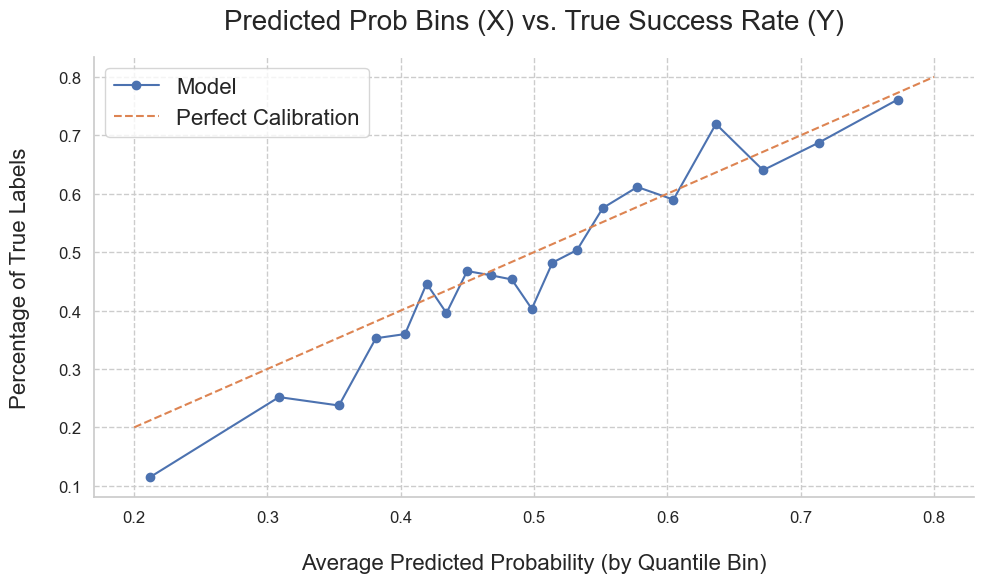

In [26]:
metrics, conf = pf.evaluate_model(data, predmod, 'bert_sent_soft_logit', bstrap=True)

In [27]:
perf_report(metrics, conf)

['accuracy = 0.63 (0.613, 0.647)',
 'f1_score = 0.63 (0.612, 0.647)',
 'precision = 0.613 (0.586, 0.638)',
 'recall = 0.604 (0.577, 0.63)',
 'roc_auc = 0.681 (0.662, 0.699)']